## Logic for importing data dynamically

In [58]:
import pandas as pd
import numpy as np
from pypots.imputation import SAITS
from pypots.optim import Adam
import random
import matplotlib.pyplot as plt
from sklearn.impute import KNNImputer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

## Loading and inspecting the data 

In [59]:
def load_file(file_path, file_type):
    """
    Loads a CSV or XLSX file and returns it as a pandas DataFrame.
    """
    try:
        if file_type.lower() == 'csv':
            df = pd.read_csv(file_path)
        elif file_type.lower() == 'xlsx':
            df = pd.read_excel(file_path)
        else:
            raise ValueError("Unsupported file type. Please use 'csv' or 'xlsx'.")
        return df
    except Exception as e:
        print(f"Error loading file: {e}")
        return None

In [60]:
df_filtered = load_file("Gasifier Data Sets/filtered_combine_data.csv", "csv")
df_useful = load_file("Gasifier Data Sets/only_useful_columns.csv","csv")
df_RD241203 = load_file("Gasifier Data Sets/RD241203.csv","csv")


In [61]:
df_filtered.head()

,Date,Time,EFG Air Flow Rate lb/hr,Primary O2 Flow Rate lb/hr,EFG System Pressure psi,Slurry Flow Rate lb/hr,Injector Cooling Water Outlet Temp F,EFG:EFG_Oxygen_Pressure_1.Value,EFG:EFG_Oxygen_Pressure_2.Value,Analyzer 2 CO2 %,...,GB CH4%,GB H2%,GB C2H4%,GB C2H2%,GB LHV [MJ/Nm3],Afterburner Air Flow Rate lb/hr,Afterburner Natural Gas Flow Rate lb/hr,EFG Quenched Gas Temp F,EFG:B_TC_1_Shallow.Value,EFG:B_TC_4_Shallow.Value
0,12/3/2024,1:39:07 PM,15.750,49.488,13.401,57.01,77.0,292.012,42.300,2.031,...,0.004,-0.052,0.108,0.004,-5.475,129.348,7.110,116.421,2285.612,2282.151
1,12/3/2024,1:39:12 PM,15.754,48.725,14.528,58.26,77.0,292.425,42.075,1.956,...,0.004,-0.052,0.099,0.004,-5.465,128.621,7.178,116.994,2289.086,2285.197
2,12/3/2024,1:39:17 PM,15.578,50.975,15.582,56.26,77.0,291.675,44.325,1.894,...,0.003,-0.052,0.098,0.004,-5.495,129.050,7.125,117.915,2292.515,2288.074
3,12/3/2024,1:39:22 PM,15.921,51.000,16.563,55.80,77.0,291.713,44.625,1.829,...,0.004,-0.052,0.098,0.004,-5.485,129.861,7.136,118.567,2295.820,2290.951
4,12/3/2024,1:39:27 PM,15.751,50.950,17.690,56.48,77.0,291.900,45.225,1.774,...,0.004,-0.026,0.089,0.004,-5.490,129.769,7.198,118.828,2299.463,2293.996


In [62]:
df_useful.head()

,Date,Time,EFG Air Flow Rate lb/hr,Primary O2 Flow Rate lb/hr,EFG System Pressure psi,Slurry Flow Rate lb/hr,EFG:EFG_Oxygen_Pressure_1.Value,EFG:EFG_Oxygen_Pressure_2.Value,Analyzer 2 CO2 %,Analyzer 3 O2 %,...,GB O2%,GB CO2%,GB CO%,GB CH4%,GB H2%,GB C2H4%,GB C2H2%,GB LHV [MJ/Nm3],EFG:B_TC_1_Shallow.Value,EFG:B_TC_4_Shallow.Value


In [63]:
df_RD241203.head(10)

,Date,Time,EFG Air Flow Rate lb/hr,EFG Gas Flow Rate lb/hr,Primary O2 Flow Rate lb/hr,Secondary O2 Flow Rate lb/hr,EFG System Pressure psi,EFG Reactor dP inH2O,Moyno Flow Rate lb/hr,EFG:EFG_Oxygen_Pressure_1.Value,...,EFG:EFG_Air_Valve.Value,EFG:EFG_Gas_Valve.Value,EFG:EFG_Badger_CV_Setpoint.Value,EFG:quench_bath_recirc_VFD.Value,EFG:Large_Netzch_Set_Point.Value,EFG:EFG_Moyno_Pump_VFD.Value,EFG:Bldg_566_City_Water_Pressure.Value,EFG:Purge_Reading.Value,EFG:Post_AB_O2.Value,Recirc_VFD_Amps
0,12/3/2024,1:39:07 PM,15.750,0.218,49.488,-0.003,13.401,-0.128,57.01,292.012,...,2213.425,2226.637,57.01,77.287,0,0,35,40,0,0
1,12/3/2024,1:39:12 PM,15.754,0.000,48.725,-0.003,14.528,-0.143,58.26,292.425,...,2213.253,2227.324,58.26,77.199,0,0,35,40,0,0
2,12/3/2024,1:39:17 PM,15.578,0.000,50.975,-0.003,15.582,-0.135,56.26,291.675,...,2213.253,2228.010,56.26,77.199,0,0,35,40,0,0
3,12/3/2024,1:39:22 PM,15.921,0.000,51.000,-0.003,16.563,-0.135,55.80,291.713,...,2213.082,2229.040,55.80,77.463,0,0,35,40,0,0
4,12/3/2024,1:39:27 PM,15.751,0.000,50.950,-0.003,17.690,-0.143,56.48,291.900,...,2212.738,2230.069,56.48,77.331,0,0,35,40,0,0
5,12/3/2024,1:39:33 PM,15.753,0.218,50.625,-0.003,19.071,-0.128,56.82,292.088,...,2212.738,2231.099,56.82,77.331,0,0,35,40,0,0
6,12/3/2024,1:39:38 PM,15.753,0.218,50.300,-0.003,20.198,-0.143,56.49,291.900,...,2212.738,2232.129,56.49,77.331,0,0,35,40,0,0
7,12/3/2024,1:39:42 PM,15.752,0.000,50.112,-0.003,21.361,-0.158,55.45,291.750,...,2212.393,2233.158,55.45,77.463,0,0,35,40,0,0
8,12/3/2024,1:39:47 PM,15.755,0.000,49.988,-0.003,22.488,-0.135,57.21,291.713,...,2212.218,2234.016,57.21,77.331,0,0,35,40,0,0
9,12/3/2024,1:39:52 PM,15.755,0.000,50.100,-0.003,23.542,-0.128,56.16,291.938,...,2212.218,2235.217,56.16,77.507,0,0,32,40,0,0


In [64]:
df_RD241203.dtypes

Date                                       object
Time                                       object
EFG Air Flow Rate lb/hr                   float64
EFG Gas Flow Rate lb/hr                   float64
Primary O2 Flow Rate lb/hr                float64
                                           ...   
EFG:EFG_Moyno_Pump_VFD.Value                int64
EFG:Bldg_566_City_Water_Pressure.Value      int64
EFG:Purge_Reading.Value                     int64
EFG:Post_AB_O2.Value                        int64
Recirc_VFD_Amps                             int64
Length: 88, dtype: object

In [65]:
df_RD241203['datetime'] = pd.to_datetime(
    df_RD241203['Date'] + ' ' + df_RD241203['Time'],
    format='%m/%d/%Y %I:%M:%S %p'
)

In [66]:
def are_columns_present(df_subset, df_full):
    """
    Returns True if all columns in df_subset are present in df_full.
    """
    return set(df_subset.columns).issubset(set(df_full.columns))

In [67]:
result = are_columns_present(df_useful, df_RD241203)
print(result)

False


## inputing real industrial time series data

**Missing Data Scenarios in High-Frequency Industrial Time Series**

In high-frequency industrial time series data, missing values can take different forms from different operational and technical events. Understanding the cause and pattern of missing data is crucial for effective data cleaning and modeling. Our current data set is from **Utah’s Advanced Energy Systems Research,” and it is clean and has no missing values. We will introduce missing data into the dataset, but we will also attempt to model real-life examples of missing data in industrial time series data.

Below are six realistic scenarios where missing data may occur, along with a description of how they typically manifest in the dataset:

1. **Short Sensor Malfunction**  
   - A single sensor malfunction, causing isolated `NaN` values in one column for a few consecutive timestamps.
   
2. **Network Malfunctions**  
   - A network interruption may cause multiple rows to be missing completely, resulting in noticeable gaps in the timestamp sequence.

3. **Maintenance Pause**  
   - Planned maintenance routines may lead to extended periods where specific sensors consistently record zeros or `NaN`.

4. **Sensor Error with Placeholder Values**  
   In the event a sensor fails, instead of stopping the data recording, the device may send extreme out-of-range values (e.g., `-9999`, `9999`, `1e6`) as placeholders for missing or invalid readings. These must be detected and treated as missing during the preprocessing stage.

5. **Time Desynchronization**  
   - System clock drift or timestamp misalignment can cause duplicate, missing, or out-of-order timestamps within the data.

6. **Catastrophic System Event**  
   - Major system failures, such as machines breaking down, can cause a loss of data across multiple sensors simultaneously.

Each scenario represents different missing values in the dataset and must be addressed carefully, taking into account the next steps in ‘cleanits’.




In [68]:
def inputing_missing_values(df_useful, df_clean):
    df = df_clean.copy()

    if 'Date' in df.columns and 'Time' in df.columns:
        df['datetime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'], format='%m/%d/%Y %I:%M:%S %p')
    else:
        raise ValueError("Expected 'Date' and 'Time' columns.")

    df = df.sort_values('datetime').reset_index(drop=True)
    target_cols = [col for col in df_useful.columns if col in df.columns]
    missing_mask = pd.DataFrame(False, index=df.index, columns=target_cols)
    rng = np.random.default_rng(seed=42)

    scenario_map = {}
    total_nan_injected = 0

    print("\n--- Injecting Missing Data ---")

    # 1. Short Sensor Glitch
    for i in range(3):
        col = random.choice(target_cols)
        row = rng.integers(10, len(df) - 10)
        df.loc[row:row+2, col] = np.nan
        missing_mask.loc[row:row+2, col] = True
        for r in range(row, row+3):
            scenario_map[(r, col)] = 'short_glitch'
        print(f"[Short Glitch] Injected NaNs at rows {row}-{row+2} in column '{col}'")
        total_nan_injected += 3

    # 2. Network Malfunction
    for i in range(2):
        if len(df) > 10:
            available_indices = df.index.tolist()
            row = rng.choice(available_indices[10:-10])
            rows_to_drop = list(range(row, row + 3))
            valid_rows_to_drop = [r for r in rows_to_drop if r in df.index]
            for r in valid_rows_to_drop:
                for col in target_cols:
                    scenario_map[(r, col)] = 'network_malfunction'
            df = df.drop(index=valid_rows_to_drop).reset_index(drop=True)
            missing_mask = missing_mask.drop(index=valid_rows_to_drop).reset_index(drop=True)
            print(f"[Network Malfunction] Dropped rows {row}-{row+2}")

    # 3. Maintenance Pause
    for i in range(3):
        col = random.choice(target_cols)
        if len(df) > 50:
            row = rng.integers(0, len(df) - 50)
            use_zero = rng.choice([True, False])
            if use_zero:
                df.loc[row:row+30, col] = 0.0
                for r in range(row, row+31):
                    scenario_map[(r, col)] = 'maintenance'
                print(f"[Maintenance Pause] Injected 0s at rows {row}-{row+30} in column '{col}'")
            else:
                df.loc[row:row+30, col] = np.nan
                missing_mask.loc[row:row+30, col] = True
                for r in range(row, row+31):
                    scenario_map[(r, col)] = 'maintenance'
                print(f"[Maintenance Pause] Injected NaNs at rows {row}-{row+30} in column '{col}'")
                total_nan_injected += 31

    # 4. Sensor Error Placeholder Values
    for i in range(3):
        col = random.choice(target_cols)
        row = rng.integers(0, len(df) - 5)
        placeholder_options = [-9999, 9999, 1e6]
        placeholder = random.choice(placeholder_options)
        df.loc[row, col] = placeholder
        missing_mask.loc[row, col] = True
        scenario_map[(row, col)] = 'placeholder'
        print(f"[Sensor Error] Inserted placeholder {placeholder} at row {row} in column '{col}'")

    # 5. Time Desynchronization
    for i in range(3):
        idx = rng.integers(1, len(df) - 2)
        coin_flip = rng.choice([True, False])
        if coin_flip:
            df.loc[idx, 'datetime'] = df.loc[idx+1, 'datetime']
            scenario_map[(idx, 'datetime')] = 'time_desync'
            print(f"[Time Desync] Made row {idx} datetime = row {idx+1}")
        else:
            df.loc[idx, 'datetime'] = df.loc[idx-1, 'datetime']
            scenario_map[(idx, 'datetime')] = 'time_desync'
            print(f"[Time Desync] Made row {idx} datetime = row {idx-1}")

    # 6. Catastrophic System Event
    for i in range(2):
        size = min(5, len(target_cols))
        cols = rng.choice(target_cols, size=size, replace=False)
        if len(df) > 20:
            row = rng.integers(0, len(df) - 20)
            for col in cols:
                df.loc[row:row+10, col] = np.nan
                missing_mask.loc[row:row+10, col] = True
                for r in range(row, row+11):
                    scenario_map[(r, col)] = 'catastrophic'
            print(f"[Catastrophic Event] Injected NaNs at rows {row}-{row+10} in columns {list(cols)}")
            total_nan_injected += 11 * size

    print(f"\n--- Total missing values manually injected (approximate): {total_nan_injected} ---\n")

    return df, missing_mask, scenario_map


In [69]:
def replace_placeholders(df, target_cols, placeholders=[-9999, 9999, 1e6]):
    for col in target_cols:
        if np.issubdtype(df[col].dtype, np.number):
            df[col] = df[col].replace(placeholders, np.nan)
    return df

In [70]:
df_corrupted, missing_mask, scenario_map = inputing_missing_values(df_useful, df_RD241203)
target_cols = [col for col in df_useful.columns if col in df_corrupted.columns]
for col in target_cols:
    if col in df_corrupted.columns:
        df_corrupted[col] = pd.to_numeric(df_corrupted[col], errors='coerce')
df_corrupted = replace_placeholders(df_corrupted, target_cols)


--- Injecting Missing Data ---
[Short Glitch] Injected NaNs at rows 146-148 in column 'ABB O2'
[Short Glitch] Injected NaNs at rows 1194-1196 in column 'EFG System Pressure psi'
[Short Glitch] Injected NaNs at rows 1012-1014 in column 'GB CO2%'
[Network Malfunction] Dropped rows 681-683
[Network Malfunction] Dropped rows 671-673
[Maintenance Pause] Injected 0s at rows 1283-1313 in column 'EFG:EFG_Oxygen_Pressure_2.Value'
[Maintenance Pause] Injected 0s at rows 1042-1072 in column 'GB CO%'
[Maintenance Pause] Injected NaNs at rows 140-170 in column 'GB CO2%'
[Sensor Error] Inserted placeholder 9999 at row 1502 in column 'GB H2%'
[Sensor Error] Inserted placeholder -9999 at row 1133 in column 'GB C2H4%'
[Sensor Error] Inserted placeholder 9999 at row 1172 in column 'GB CO%'
[Time Desync] Made row 1107 datetime = row 1106
[Time Desync] Made row 792 datetime = row 793
[Time Desync] Made row 1295 datetime = row 1296
[Catastrophic Event] Injected NaNs at rows 676-686 in columns ['ABB CH4', 

In [71]:
injected_cols = set([col for (_, col), glitch in scenario_map.items() if col in df_corrupted.columns])
print(f"\n[SUMMARY] Injected glitches affected {len(injected_cols)} columns:")
for col in sorted(injected_cols):
    print(f" - {col}")


[SUMMARY] Injected glitches affected 25 columns:
 - ABB CH4
 - ABB CO
 - ABB CO2
 - ABB O2
 - Analyzer 2 CO2 %
 - Analyzer 3 CO2%
 - Analyzer 3 O2 %
 - Date
 - EFG Air Flow Rate lb/hr
 - EFG System Pressure psi
 - EFG:B_TC_1_Shallow.Value
 - EFG:B_TC_4_Shallow.Value
 - EFG:EFG_Oxygen_Pressure_1.Value
 - EFG:EFG_Oxygen_Pressure_2.Value
 - GB C2H2%
 - GB C2H4%
 - GB CH4%
 - GB CO%
 - GB CO2%
 - GB H2%
 - GB LHV [MJ/Nm3]
 - GB O2%
 - Primary O2 Flow Rate lb/hr
 - Time
 - datetime


In [72]:
print("Column dtypes before coercion:")
print(df_corrupted[target_cols].dtypes)

Column dtypes before coercion:
Date                               float64
Time                               float64
EFG Air Flow Rate lb/hr            float64
Primary O2 Flow Rate lb/hr         float64
EFG System Pressure psi            float64
EFG:EFG_Oxygen_Pressure_1.Value    float64
EFG:EFG_Oxygen_Pressure_2.Value    float64
Analyzer 2 CO2 %                   float64
Analyzer 3 O2 %                    float64
Analyzer 3 CO2%                    float64
ABB CH4                            float64
ABB CO                             float64
ABB CO2                            float64
ABB O2                             float64
GB O2%                             float64
GB CO2%                            float64
GB CO%                             float64
GB CH4%                            float64
GB H2%                             float64
GB C2H4%                           float64
GB C2H2%                           float64
GB LHV [MJ/Nm3]                    float64
EFG:B_TC_1_Shallow.Valu

## Checking if the self imputed missing values actually work

In [73]:
missing_summary = df_corrupted.isna().sum()
print(missing_summary[missing_summary > 0])

Date                       1545
Time                       1545
EFG Air Flow Rate lb/hr      11
EFG System Pressure psi      25
Analyzer 2 CO2 %             11
Analyzer 3 CO2%              11
ABB CH4                      11
ABB CO2                      11
ABB O2                        3
GB CO2%                      34
GB CO%                        1
GB H2%                       12
GB C2H4%                      1
GB LHV [MJ/Nm3]              22
dtype: int64


In [74]:
df_simulated = df_corrupted.sort_values('datetime').reset_index(drop=True)
time_diffs = df_simulated['datetime'].diff().dt.total_seconds()
print(time_diffs[time_diffs > 5])

5       6.0
11      6.0
16      6.0
18      6.0
19      6.0
       ... 
1522    6.0
1529    6.0
1534    6.0
1537    6.0
1542    6.0
Name: datetime, Length: 308, dtype: float64


In [75]:
target_cols = [col for col in df_useful.columns if col in df_corrupted.columns]

placeholders = [-9999, 9999, 1e6]
for val in placeholders:
    hits = (df_corrupted[target_cols] == val).sum()
    print(f"Placeholder {val} found in columns:")
    print(hits[hits > 0])

Placeholder -9999 found in columns:
Series([], dtype: int64)
Placeholder 9999 found in columns:
Series([], dtype: int64)
Placeholder 1000000.0 found in columns:
Series([], dtype: int64)


In [76]:
duplicates = df_simulated['datetime'].duplicated().sum()
print(f"Number of duplicated timestamps: {duplicates}")

Number of duplicated timestamps: 3


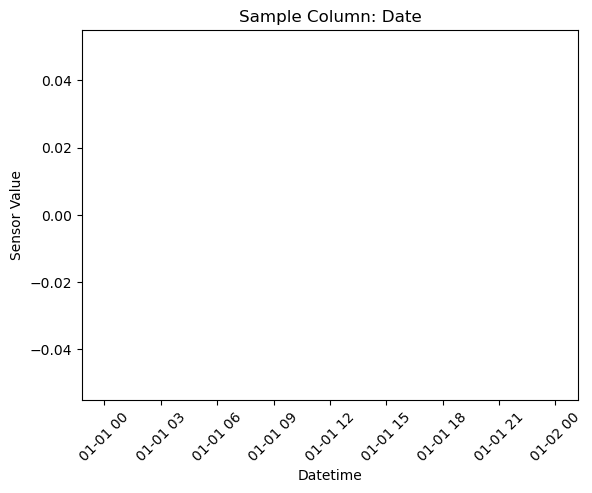

In [77]:
sample_col = random.choice(target_cols)
plt.plot(df_simulated['datetime'], df_simulated[sample_col])
plt.title(f"Sample Column: {sample_col}")
plt.xlabel('Datetime')
plt.ylabel('Sensor Value')
plt.xticks(rotation=45)
plt.show()

## Creating helper functions that will help look for and diagnose each of the six scenarios described above.

In [78]:
def detect_short_nan_blocks(series, max_gap=3):
    """Detect short isolated NaN blocks in a column."""
    is_nan = series.isna()
    groups = (is_nan != is_nan.shift()).cumsum()
    sizes = is_nan.groupby(groups).sum()
    mask = is_nan & groups.map(lambda x: sizes[x] <= max_gap)
    return mask

def detect_time_gaps(df, expected_seconds=5):
    """Detect rows where time gap exceeds expected frequency."""
    time_diffs = df['datetime'].diff().dt.total_seconds()
    gap_indices = time_diffs[time_diffs > expected_seconds].index
    return gap_indices

def detect_long_blocks(series, min_length=20, zero_included=True):
    """Detect long blocks of NaN or zeros."""
    if zero_included:
        invalid = series.isna() | (series == 0)
    else:
        invalid = series.isna()
    groups = (invalid != invalid.shift()).cumsum()
    sizes = invalid.groupby(groups).sum()
    mask = invalid & groups.map(lambda x: sizes[x] >= min_length)
    return mask

def detect_placeholder_values(df, target_cols, placeholders=[-9999, 9999, 1e6]):
    """Detect placeholder values in dataframe."""
    placeholder_hits = {}
    for col in target_cols:
        hits = df[col].isin(placeholders)
        if hits.any():
            placeholder_hits[col] = hits
    return placeholder_hits

def detect_time_desync(df):
    """Detect duplicated or non-monotonic timestamps."""
    duplicated = df['datetime'].duplicated()
    non_monotonic = df['datetime'].diff().dt.total_seconds() < 0
    return duplicated | non_monotonic

def detect_catastrophic_blocks(df, target_cols, min_cols=5, min_rows=10):
    """Detect blocks where many columns go NaN simultaneously."""
    block_mask = (df[target_cols].isna().sum(axis=1) >= min_cols)
    block_groups = (block_mask != block_mask.shift()).cumsum()
    block_sizes = block_mask.groupby(block_groups).sum()
    true_blocks = block_mask & block_groups.map(lambda x: block_sizes[x] >= min_rows)
    return true_blocks

def impute_interpolate(df, col):
    """Interpolates missing values in a single column using datetime index."""
    df = df.copy()
    df = df.set_index('datetime')
    df[col] = df[col].interpolate(method='time')
    df = df.reset_index()
    return df

def impute_fill_zero_or_median(df, col):
    """Fill long blocks with median or zero depending on content."""
    if df[col].median() != 0:
        df[col] = df[col].fillna(df[col].median())
    else:
        df[col] = df[col].fillna(0)
    return df

def impute_knn(df, target_cols, n_neighbors=5):
    """
    Apply KNN imputation only to numeric columns that contain some NaNs
    and at least one non-NaN value.
    """
    numeric_cols = [col for col in target_cols if np.issubdtype(df[col].dtype, np.number)]

    cols_with_nans = [col for col in numeric_cols if 0 < df[col].isna().sum() < len(df)]

    if not cols_with_nans:
        return df

    imputer = KNNImputer(n_neighbors=n_neighbors)
    imputed_values = imputer.fit_transform(df[cols_with_nans])

    imputed_df = pd.DataFrame(imputed_values, columns=cols_with_nans, index=df.index)
    df[cols_with_nans] = imputed_df
    return df


## Logic to handle each of the six scenarios.

In [79]:
def handle_short_sensor_glitch(df, target_cols, scenario_map, verbose=True):
    affected = [(row, col) for (row, col), glitch in scenario_map.items() if glitch == 'short_glitch']
    if not affected:
        if verbose:
            print("[Short Sensor Glitch] No injected short glitches found.")
        return df

    from collections import defaultdict
    col_rows = defaultdict(set)
    for row, col in affected:
        if col in df.columns:
            col_rows[col].add(row)

    for col, rows in col_rows.items():
        if df[col].isna().sum() == 0:
            continue
        if verbose:
            print(f"[Short Sensor Glitch] Interpolating {len(rows)} points in '{col}'")
        df = impute_interpolate(df, col)

    return df

def handle_network_malfunction(df, target_cols, scenario_map, verbose=True):
    """Fix only rows where network malfunctions (row drops) were manually injected."""
    network_rows = set()

    for row, glitch_type in scenario_map.items():
        if glitch_type == 'network':
            network_rows.add(row)

    if not network_rows:
        if verbose:
            print("[Network Malfunction] No missing rows needing repair.")
        return df

    gap_indices = detect_time_gaps(df)
    if verbose:
        print(f"[Network Malfunction] Detected {len(gap_indices)} gaps after network malfunctions.")

    for idx in sorted(gap_indices, reverse=True):
        expected_time = df.loc[idx-1, 'datetime'] + pd.Timedelta(seconds=5)
        while expected_time < df.loc[idx, 'datetime']:
            new_row = df.iloc[[idx-1]].copy()
            new_row['datetime'] = expected_time
            new_row[target_cols] = np.nan
            df = pd.concat([df.iloc[:idx], new_row, df.iloc[idx:]]).reset_index(drop=True)
            expected_time += pd.Timedelta(seconds=5)
            idx += 1

    return df


def handle_maintenance_pause(df, target_cols, scenario_map, verbose=True):
    """Fix rows that were part of maintenance pauses (NaNs or zeros) based on scenario_map."""
    from collections import defaultdict

    maintenance_rows = defaultdict(set)
    for (row, col), glitch in scenario_map.items():
        if glitch == 'maintenance' and col in df.columns:
            maintenance_rows[col].add(row)

    if not maintenance_rows:
        if verbose:
            print("[Maintenance Pause] No maintenance events found.")
        return df

    for col, rows in maintenance_rows.items():
        if not np.issubdtype(df[col].dtype, np.number):
            continue

        affected = df.loc[list(rows), col]
        if affected.isna().any() or (affected == 0).any():
            if verbose:
                print(f"[Maintenance Pause] {col}: Imputing {len(rows)} rows (NaNs or 0s).")
            df = impute_fill_zero_or_median(df, col)

    return df

def handle_sensor_placeholder_values(df, target_cols, scenario_map=None, verbose=True):
    """
    Detect and replace placeholder values in target columns regardless of scenario_map.
    This makes the pipeline more robust in case scenario_map is missing or incomplete.
    """
    placeholders = [-9999, 9999, 1e6]
    for col in target_cols:
        if col in df.columns:
            mask = df[col].isin(placeholders)
            if mask.any():
                df.loc[mask, col] = np.nan
                df = impute_interpolate(df, col)
                if verbose:
                    print(f"[Sensor Placeholder] {col}: Placeholder values replaced and interpolated.")
    return df

def handle_time_desync(df, target_cols, scenario_map, verbose=True):
    """Fix only the rows that were affected by time desync events based on scenario map."""
    desync_rows = [row for (row, col), glitch_type in scenario_map.items() if glitch_type == 'time_desync']

    if not desync_rows:
        if verbose:
            print("[Time Desync] No time desync events found.")
        return df

    if verbose:
        print(f"[Time Desync] Fixing {len(desync_rows)} time desync rows.")

    df = df.sort_values('datetime').reset_index(drop=True)

    df = df.drop_duplicates(subset='datetime')
    return df

def handle_catastrophic_event(df, target_cols, scenario_map, verbose=True):
    """Fix blocks affected by catastrophic events ONLY."""
    catastrophic_rows = [row for (row, col), glitch_type in scenario_map.items() if glitch_type == 'catastrophic']

    if not catastrophic_rows:
        if verbose:
            print("[Catastrophic Event] No catastrophic events found.")
        return df

    block_mask = (df[target_cols].isna().sum(axis=1) >= 5)
    block_groups = (block_mask != block_mask.shift()).cumsum()
    block_sizes = block_mask.groupby(block_groups).sum()
    true_blocks = block_mask & block_groups.map(lambda x: block_sizes[x] >= 10)

    if true_blocks.any():
        rows_to_impute = df.index[true_blocks]
        affected_df = df.loc[rows_to_impute, target_cols]

        cols_to_use = [col for col in affected_df.columns if affected_df[col].isna().sum() > 0 and affected_df[col].notna().sum() > 0]

        if cols_to_use:
            imputer = KNNImputer(n_neighbors=5)
            imputed_array = imputer.fit_transform(affected_df[cols_to_use])

            imputed_df = pd.DataFrame(imputed_array, columns=cols_to_use, index=rows_to_impute)
            df.loc[rows_to_impute, cols_to_use] = imputed_df

            if verbose:
                print(f"[Catastrophic Event] Imputed {len(rows_to_impute)} rows across {len(cols_to_use)} columns using KNN.")

    return df



In [80]:
def clean_all(df, target_cols, scenario_map, verbose=True):
    df = handle_short_sensor_glitch(df, target_cols, scenario_map, verbose)
    df = handle_network_malfunction(df, target_cols, scenario_map, verbose)
    df = handle_maintenance_pause(df, target_cols, scenario_map, verbose)
    df = handle_sensor_placeholder_values(df, target_cols, scenario_map, verbose)
    df = handle_time_desync(df, target_cols, scenario_map, verbose)
    df = handle_catastrophic_event(df, target_cols, scenario_map, verbose)

    if verbose:
        print("[Final Sweep] Applying KNN imputation on remaining missing values...")
    df = impute_knn(df, target_cols)

    return df


In [81]:
import matplotlib.pyplot as plt

def plot_side_by_side(df_before, df_after, cols, datetime_col='datetime', figsize_per_row=(12,2)):
    """
    Plots each column in `cols` on its own row with two panels (BEFORE vs AFTER).
    Wider plots and rotated/adjusted y-labels.
    """
    n = len(cols)
    fig, axes = plt.subplots(n, 2, 
                             figsize=(figsize_per_row[0], figsize_per_row[1] * n),
                             sharex=True,
                             gridspec_kw={'width_ratios': [1, 1]})
    if n == 1:
        axes = axes.reshape(1,2)

    for i, col in enumerate(cols):
        if col not in df_before.columns or col not in df_after.columns:
            print(f"[SKIP] Column '{col}' not found in one of the dataframes.")
            continue
        if df_before[col].isna().all() or df_after[col].isna().all():
            print(f"[SKIP] Column '{col}' is all NaNs in before/after.")
            continue

        axb, axa = axes[i]
        # BEFORE
        axb.plot(df_before[datetime_col], df_before[col], linewidth=0.8)
        axb.set_title("BEFORE", fontsize=9)
        axb.set_ylabel(col, fontsize=7, rotation=0, labelpad=60, ha='right', va='center')
        axb.tick_params(labelsize=6)

        # AFTER
        axa.plot(df_after[datetime_col], df_after[col], linewidth=0.8)
        axa.set_title("AFTER", fontsize=9)
        axa.tick_params(labelsize=6, labelrotation=45)

        clean_vals = (
            pd.concat([
                df_before[col].replace([-9999,9999,1e6], np.nan),
                df_after[col]
            ])
            .dropna()
        )
        if not clean_vals.empty:
            mn, mx = clean_vals.min(), clean_vals.max()
            pad = (mx-mn)*0.05
            axb.set_ylim(mn-pad, mx+pad)
            axa.set_ylim(mn-pad, mx+pad)

    for ax in axes.flatten():
        ax.grid(True, alpha=0.3)
    print("Final target columns:", target_cols)

    fig.tight_layout(h_pad=1.5)
    plt.show()


Final target columns: ['Date', 'Time', 'EFG Air Flow Rate lb/hr', 'Primary O2 Flow Rate lb/hr', 'EFG System Pressure psi', 'EFG:EFG_Oxygen_Pressure_1.Value', 'EFG:EFG_Oxygen_Pressure_2.Value', 'Analyzer 2 CO2 %', 'Analyzer 3 O2 %', 'Analyzer 3 CO2%', 'ABB CH4', 'ABB CO', 'ABB CO2', 'ABB O2', 'GB O2%', 'GB CO2%', 'GB CO%', 'GB CH4%', 'GB H2%', 'GB C2H4%', 'GB C2H2%', 'GB LHV [MJ/Nm3]', 'EFG:B_TC_1_Shallow.Value', 'EFG:B_TC_4_Shallow.Value']


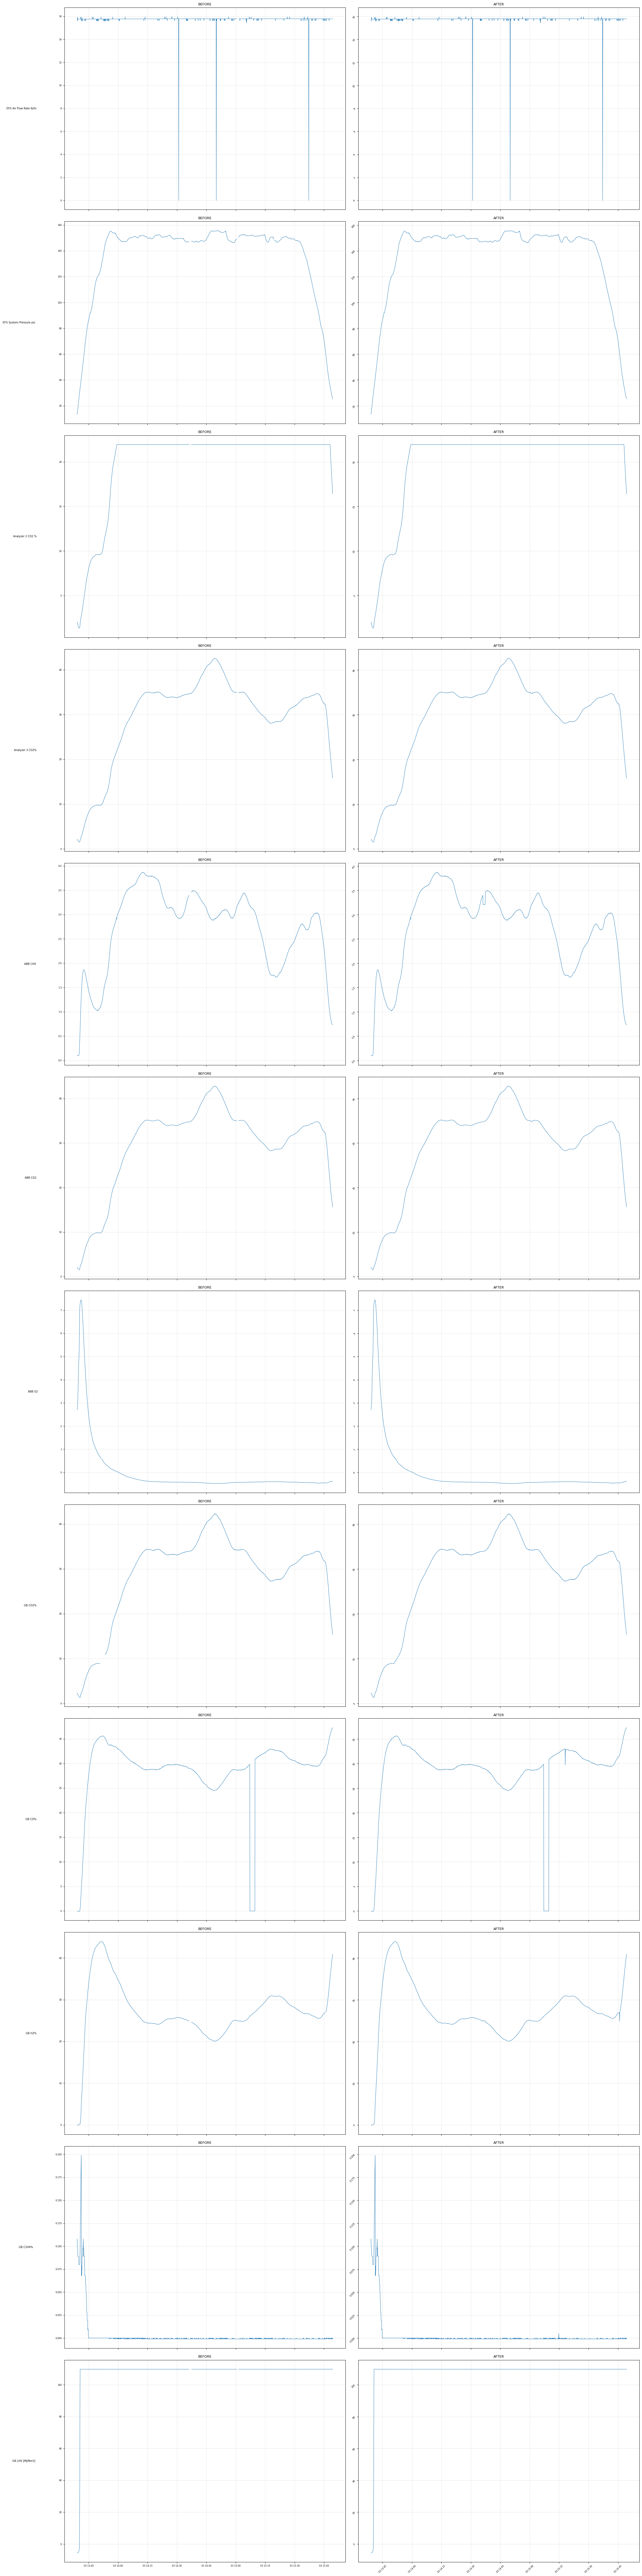

In [82]:
df_cleaned = clean_all(df_corrupted.copy(), target_cols, scenario_map, verbose=False)

cols_to_plot = [
    col for col in target_cols
    if col not in ['Date', 'Time'] and df_corrupted[col].isna().sum() > 0
]
plot_side_by_side(
    df_before = df_corrupted,
    df_after = df_cleaned,
    cols = cols_to_plot,
    datetime_col = 'datetime',
    figsize_per_row = (24, 8)
)


## Now we will prepare the PyPOTS input

In [83]:
def make_pypots_dataset(df, target_cols, window_size=48):
    """
    Slice a DataFrame into 3D format: (n_samples, n_steps, n_features).
    Each sample is a window of length `window_size`.
    """
    df_sorted = df.sort_values("datetime").reset_index(drop=True)
    data = df_sorted[target_cols].to_numpy()

    n_samples = data.shape[0] - window_size + 1
    n_features = len(target_cols)

    X = np.zeros((n_samples, window_size, n_features))

    for i in range(n_samples):
        X[i] = data[i:i+window_size]

    return X
def make_missing_mask(X):
    """
    Create missing value mask: 1 = observed, 0 = missing.
    Input X is a 3D array (n_samples, n_steps, n_features).
    """
    return (~np.isnan(X)).astype(int)

def rebuild_dataframe(X_imputed, df_base, target_cols, window_size=48):
    """
    Rebuild a full DataFrame from PyPOTS imputed 3D tensor.
    Averages overlapping windows.
    """
    n_rows = X_imputed.shape[0] + window_size - 1
    n_features = len(target_cols)

    counts = np.zeros((n_rows, n_features))
    values = np.zeros((n_rows, n_features))

    for i in range(X_imputed.shape[0]):
        values[i:i+window_size] += X_imputed[i]
        counts[i:i+window_size] += 1

    mean_values = values / counts

    df_imputed = pd.DataFrame(mean_values, columns=target_cols)
    df_imputed["datetime"] = df_base["datetime"].iloc[:n_rows].values

    return df_imputed

# Build PyPOTS inputs
X = make_pypots_dataset(df_corrupted, target_cols, window_size=48)
missing_mask = make_missing_mask(X)

# Build datasets for PyPOTS
dataset_for_training = {"X": X}
dataset_for_validating = {"X": X, "X_ori": X}
dataset_for_testing = {"X": X}


# Train SAITS model
saits = SAITS(
    n_steps=48,
    n_features=len(target_cols),
    d_model=256,
    n_layers=2,
    d_ffn=128,
    n_heads=4,
    d_k=64,
    d_v=64,
    batch_size=32,
    epochs=20,
    optimizer=Adam(lr=1e-3),
    patience=3,
    device=None,
)

saits.fit(train_set=dataset_for_training, val_set=dataset_for_validating)

# Predict missing values
saits_results = saits.predict(dataset_for_testing)
X_imputed = saits_results["imputation"]

# Recover full imputed DataFrame
df_pypots_cleaned = rebuild_dataframe(X_imputed, df_corrupted, target_cols, window_size=48)


2025-04-29 04:54:26 [INFO]: No given device, using default device: cpu
2025-04-29 04:54:26 [WARNING]: ‼️ saving_path not given. Model files and tensorboard file will not be saved.
2025-04-29 04:54:26 [INFO]: Using customized MAE as the training loss function.
2025-04-29 04:54:26 [INFO]: Using customized MSE as the validation metric function.


2025-04-29 04:54:26 [INFO]: SAITS initialized with the given hyperparameters, the number of trainable parameters: 1,356,128
2025-04-29 04:54:30 [INFO]: Epoch 001 - training loss (MAE): 492.4506, validation MSE: 0.0000
2025-04-29 04:54:34 [INFO]: Epoch 002 - training loss (MAE): 472.2007, validation MSE: 0.0000
2025-04-29 04:54:38 [INFO]: Epoch 003 - training loss (MAE): 450.7639, validation MSE: 0.0000
2025-04-29 04:54:42 [INFO]: Epoch 004 - training loss (MAE): 412.4763, validation MSE: 0.0000
2025-04-29 04:54:42 [INFO]: Exceeded the training patience. Terminating the training procedure...
2025-04-29 04:54:42 [INFO]: Finished training. The best model is from epoch#1.


In [84]:
# 1. Build a version of corrupted that matches df_pypots_cleaned shape
window_size = 48  # same window size you used

# 1. Drop first (window_size-1) rows to match
df_corrupted_trimmed = df_corrupted.iloc[window_size-1:].reset_index(drop=True)

# 2. Trim df_pypots_cleaned too (correct alignment)
df_pypots_cleaned_aligned = df_pypots_cleaned.iloc[:len(df_corrupted_trimmed)].reset_index(drop=True)

# 3. Align ground truth
df_true_aligned = df_RD241203.set_index('datetime').loc[df_corrupted_trimmed['datetime']].reset_index()

# 4. Build mask
new_missing_mask = df_corrupted_trimmed[target_cols].isna()

# 5. 🔥 Coerce types just to be safe
for col in target_cols:
    df_true_aligned[col] = pd.to_numeric(df_true_aligned[col], errors='coerce')
    df_pypots_cleaned_aligned[col] = pd.to_numeric(df_pypots_cleaned_aligned[col], errors='coerce')

# 6. Evaluate
all_true = []
all_pred = []

for col in target_cols:
    mask = new_missing_mask[col]
    true_col = df_true_aligned[col].iloc[mask.values]
    pred_col = df_pypots_cleaned_aligned[col].iloc[mask.values]

    valid = ~np.isnan(true_col.values) & ~np.isnan(pred_col.values)
    all_true.extend(true_col.values[valid])
    all_pred.extend(pred_col.values[valid])

all_true = np.array(all_true)
all_pred = np.array(all_pred)

# 7. Results
print(f"SAITS MAE:  {mean_absolute_error(all_true, all_pred):.4f}")
print(f"SAITS RMSE: {mean_squared_error(all_true, all_pred) ** 0.5:.4f}")
print(f"SAITS R²:   {r2_score(all_true, all_pred):.4f}")


SAITS MAE:  0.8206
SAITS RMSE: 1.1560
SAITS R²:   0.9995


## Analyzing the perfomance of the imputation. We will use the original dataframe and compare it with the dataframe that has gone through our pipeline.

In [85]:
target_cols = [col for col in target_cols if np.issubdtype(df_corrupted[col].dtype, np.number)]
new_missing_mask = df_corrupted[target_cols].isna()

df_cleaned_aligned = df_cleaned.set_index('datetime').loc[df_corrupted['datetime']].reset_index()

if 'datetime' not in df_RD241203.columns:
    df_RD241203['datetime'] = pd.to_datetime(df_RD241203['Date'] + ' ' + df_RD241203['Time'], format='%m/%d/%Y %I:%M:%S %p')

df_true_aligned = df_RD241203.set_index('datetime').loc[df_corrupted['datetime']].reset_index()

# 🔥 Fix type coercion
for col in target_cols:
    df_true_aligned[col] = pd.to_numeric(df_true_aligned[col], errors='coerce')
    df_cleaned_aligned[col] = pd.to_numeric(df_cleaned_aligned[col], errors='coerce')

# Continue
all_true = []
all_pred = []

for col in target_cols:
    mask = new_missing_mask[col]
    
    true_col = df_true_aligned[col][mask]
    pred_col = df_cleaned_aligned[col][mask]

    valid = ~np.isnan(true_col.values) & ~np.isnan(pred_col.values)
    true_valid = true_col.values[valid]
    pred_valid = pred_col.values[valid]

    all_true.extend(true_valid)
    all_pred.extend(pred_valid)

all_true = np.array(all_true)
all_pred = np.array(all_pred)

mae = mean_absolute_error(all_true, all_pred)
rmse = mean_squared_error(all_true, all_pred)
r2 = r2_score(all_true, all_pred)

print(f"MAE (Mean Absolute Error): {mae:.4f}")
print(f"RMSE (Root Mean Squared Error): {rmse:.4f}")
print(f"R² Score: {r2:.4f}")


MAE (Mean Absolute Error): 0.1711
RMSE (Root Mean Squared Error): 0.1405
R² Score: 1.0000


In [86]:
results = []

for col in target_cols:
    mask = new_missing_mask[col]

    true_col = df_true_aligned[col][mask]
    pred_col = df_cleaned_aligned[col][mask]

    valid = ~np.isnan(true_col.values) & ~np.isnan(pred_col.values)
    true_valid = true_col.values[valid]
    pred_valid = pred_col.values[valid]

    if len(true_valid) > 0:
        mae = mean_absolute_error(true_valid, pred_valid)
        rmse = mean_squared_error(true_valid, pred_valid)
        r2 = r2_score(true_valid, pred_valid)
        results.append((col, mae, rmse, r2))

metrics_df = pd.DataFrame(results, columns=['Column', 'MAE', 'RMSE', 'R2'])

metrics_df = metrics_df.sort_values(by='MAE')

print(metrics_df)

                     Column       MAE       RMSE          R2
2          Analyzer 2 CO2 %  0.002223   0.000006   -0.131068
0   EFG Air Flow Rate lb/hr  0.002653   0.000008   -2.479592
6                    ABB O2  0.003667   0.000014    0.265483
10                 GB C2H4%  0.006000   0.000036         NaN
11          GB LHV [MJ/Nm3]  0.012636   0.000237   -0.616073
1   EFG System Pressure psi  0.062565   0.012284    0.992566
5                   ABB CO2  0.151545   0.023138 -133.832065
3           Analyzer 3 CO2%  0.193182   0.037814  -75.449039
4                   ABB CH4  0.220818   0.049214 -107.613924
7                   GB CO2%  0.310765   0.133705    0.997286
9                    GB H2%  0.355600   0.429081   -0.108189
8                    GB CO%  3.206000  10.278436         NaN


c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:1187: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:1187: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
